<a href="https://colab.research.google.com/github/Irinoise/mri-segmentation/blob/main/MRI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/drive/1DedzlRT-yCVz4cyZmy05TblRspbiVIBU" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI segmentation

This notebook describes a way to solve the task of brain MRI images segmentation.

The purpose of the work is developing a neural network which will be able to detect 5 groups of brain structures, such as ventricles, amygdala, brainstem, hippocampus and gray matter.

In [ ]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment

In [ ]:
!pip install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

In [ ]:
!pip install --quiet --upgrade torchio
import torchio

In [5]:
!pip install --quiet --upgrade unet
from unet import UNet

In [ ]:
!git clone https://github.com/deepmind/surface-distance.git
!pip install surface-distance/
from surface_distance import metrics

In [1]:
import enum
import gc
from google.colab import drive
from IPython.display import clear_output
import multiprocessing
import nibabel
import numpy as np
import os
import pandas as pd
import random
import scipy as sp
import scipy.misc
import sys
import time
import tqdm

import torch
from torch import optim
from torch.autograd import Function, Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.utils.data import DataLoader, Subset

from torchio import AFFINE, DATA, PATH, TYPE, STEM
from torchio import transforms
from torchio.transforms import (
    RandomFlip,
    RandomGamma,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomBlur,
    RandomAnisotropy,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit

import warnings
import matplotlib.pyplot as plt
%matplotlib inline

Using Comet ML tool for logging and visualizing the results of experiments:

In [ ]:
experiment = Experiment(
    api_key="someAPIkey",
    project_name="general",
    workspace="irinashakhova",
)

Using Google Drive to download input data (the data was preloaded onto Google Drive) and save the results of experiments:

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/anat/fs_segmentation' # training data
model_dir = '/content/drive/My Drive/models' # saved models
scores_dir = '/content/drive/My Drive/scores/' # logged scores
test_dir = '/content/drive/My Drive/test/' # test objects

patology_data_dir = '/content/drive/My Drive/la5' # demonstrational dataset (contains of MRI images with patological structures)

Downloading data and creating DataFrame from downloaded CSV:

In [ ]:
labels_dir  = '/content/drive/My Drive/anat/'
labels = pd.read_csv(labels_dir + 'unrestricted_hcp_freesurfer.csv')

In [ ]:
data_list = pd.DataFrame(columns = ['Subject','norm','aseg']) # 'Subject' – id of record; 'norm' – link to T1-weighted MRI image; 'aseg' – link to segmentation mask

In [ ]:
data_list['Subject'] = labels['Subject']

In [ ]:
for i in tqdm(os.listdir(data_dir)):
  for j in range(0, len(data_list['Subject'])):

    if str(data_list['Subject'].iloc[j]) in i:
      if 'norm' in i: # copying path to the column norm
        data_list['norm'].iloc[j] = data_dir +'/'+ i
      elif 'aseg' in i: # copying path to second column
        data_list['aseg'].iloc[j] = data_dir +'/'+ i

data_list.dropna(inplace= True)

  0%|          | 0/854 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 854/854 [00:03<00:00, 242.02it/s]


In [ ]:
data_list.head(10)

,Subject,norm,aseg
4,101006,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
5,101107,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
6,101309,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
7,101410,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
8,101915,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
9,102008,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
10,102109,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
11,102311,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
12,102513,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...
13,102614,/content/drive/My Drive/anat/fs_segmentation/H...,/content/drive/My Drive/anat/fs_segmentation/H...


Visualisation of normalised images and segmentation mask (an example):

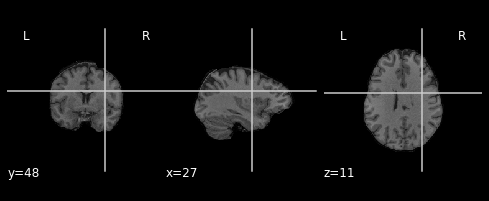

In [ ]:
# visualising normalised image
img = nilearn.image.load_img(data_list['norm'].iloc[0])
plotting.plot_anat(img)

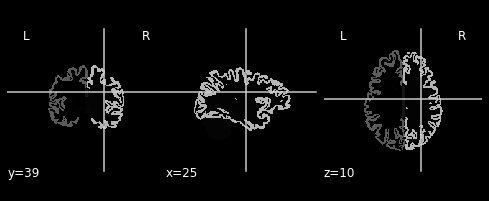

In [ ]:
# visualising segmentation
img = nilearn.image.load_img(data_list['aseg'].iloc[0])
plotting.plot_anat(img)

Using `TorchIO` library (https://torchio.readthedocs.io/) as a primary tool for preprocessing of brain MRI images:

In [ ]:
"""
    Code adapted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO:
        a Python library for efficient loading, preprocessing,
        augmentation and patch-based sampling of medical images in deep learning.

"""

CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

MRI = 'MRI'
LABEL = 'LABEL'

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(inputs, targets, transform):
    """
    The function creates dataset from the list of files from customised dataloader.
    """
    subjects = []
    for (image_path, label_path) in zip(inputs, targets):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)

    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)

    return  dataset , subjects

In [ ]:
data, subjects = get_torchio_dataset(data_list['norm'], data_list['aseg'], False)

A central cut of MRI image and segmentation mask visualization:

In [ ]:
def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]

    elif isinstance(img, nibabel.nifti1.Nifti1Image):
        img = img.get_fdata()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 5, 5))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])

    plt.show()

Dataset size: 427
Image shape: (1, 256, 256, 256)
Segmentation shape: (1, 256, 256, 256)


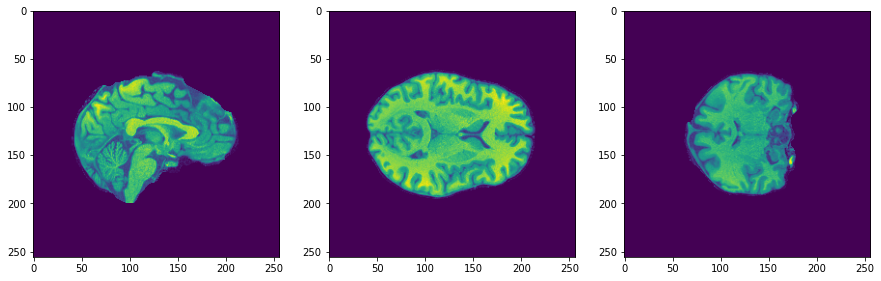

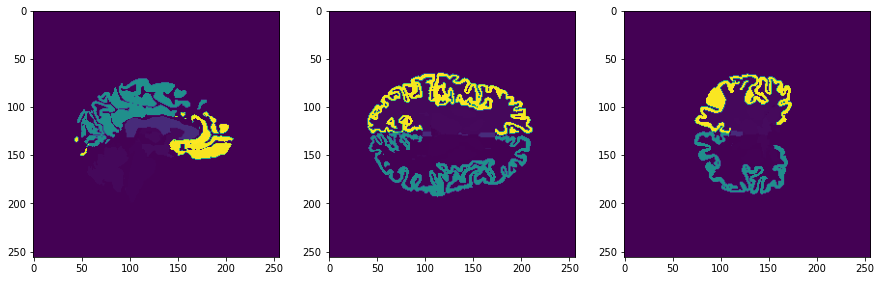

In [ ]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

Applying transformations and splitting into training and validation sets:

In [ ]:
num_subjects = len(data)
training_split_ratio = 0.9

crop = (49, 22, 49, 47, 19, 28)

training_transform = Compose([
    transforms.Crop(crop),
    transforms.Pad(4),
    RandomAnisotropy(p=0.25),
    RandomBlur(p=0.25),
    RandomBiasField(p=0.25),
    RandomFlip(axes=(0,)),
])

validation_transform = None

training_subjects, validation_subjects = train_test_split(
    subjects, train_size=training_split_ratio, shuffle=True, random_state=42
)

training_set = torchio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 384 subjects
Validation set: 43 subjects


Coding brain structures using their labels from the input dataset to get target labels:

In [ ]:
VENTRCL =  [4, 5, 14, 15, 43, 44, 72] # 1
BRN_STEM = [16] # 2
HIPPOCMPS = [17, 53] # 3
AMYGDL = [18, 54] # 4
GM = [1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
       1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
       2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035] # 5

LABELS = VENTRCL + BRN_STEM + HIPPOCMPS + AMYGDL + GM # all of interest

In [ ]:
def prepare_aseg(targets):
    targets = np.where(np.isin(targets, LABELS, invert = True), 0, targets)
    targets = np.where(np.isin(targets, VENTRCL), 1, targets)
    targets = np.where(np.isin(targets, BRN_STEM), 2, targets)
    targets = np.where(np.isin(targets, HIPPOCMPS), 3, targets)
    targets = np.where(np.isin(targets, AMYGDL), 4, targets)
    targets = np.where(np.isin(targets, GM), 5, targets)
    return targets

In [ ]:
def prepare_batch(batch, device):
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets = torch.from_numpy(prepare_aseg(targets))
    targets = targets.to(device)
    return inputs, targets

Functions for counting multiclass loss:

In [ ]:
class DiceLoss(nn.Module):
    """ Multiclass loss"""
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        dice = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - dice
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes, class_wise_dice

Describing neural network architecture, choosing optimizer and scheduler:

In [ ]:
def get_model_and_optimizer(device, num_encoding_blocks=4, out_channels_first_layer=8, patience=3):
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=num_encoding_blocks,
        out_channels_first_layer=out_channels_first_layer,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)

  optimizer = torch.optim.AdamW(model.parameters())
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)

  return model, optimizer, scheduler

Patch-based sampling using TorchIO library:

In [ ]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 16
num_training_workers = 2
num_validation_workers = 1

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size, shuffle=False)

Saving scores into CSV:

In [ ]:
def scores_to_csv(train_loss, train_dice, train_dice_by_class, val_loss, val_dice, val_dice_by_class, epoch_idx, weights_stem):
    scores_dict = {
        'avg_train_loss': train_loss,
        'avg_train_dice': train_dice,
        'avg_val_loss': val_loss,
        'avg_val_dice': val_dice,
        'train_dice_0': train_dice_by_class['0'],
        'train_dice_1': train_dice_by_class['1'],
        'train_dice_2': train_dice_by_class['2'],
        'train_dice_3': train_dice_by_class['3'],
        'train_dice_4': train_dice_by_class['4'],
        'train_dice_5': train_dice_by_class['5'],
        'val_dice_0': val_dice_by_class['0'],
        'val_dice_1': val_dice_by_class['1'],
        'val_dice_2': val_dice_by_class['2'],
        'val_dice_3': val_dice_by_class['3'],
        'val_dice_4': val_dice_by_class['4'],
        'val_dice_5': val_dice_by_class['5']
    }
    df_scores = pd.DataFrame(data=scores_dict, index=[epoch_idx])
    output_path = scores_dir + f'scores_{weights_stem}.csv'
    df_scores.to_csv(output_path, mode='a', header=not os.path.exists(output_path))

Functions for training the ML model:

In [ ]:
def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler=None):
    is_training = action == Action.TRAIN
    dice_loss = DiceLoss(6)
    epoch_losses = []
    epoch_score = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs.float())
            batch_losses, score_dice = dice_loss(logits,
                                                 targets.squeeze(1),
                                                 softmax=True)

            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
            epoch_score.append(score_dice)
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item(), epoch=epoch_idx)

    avg_loss = np.array(epoch_losses).mean()

    if scheduler:
        scheduler.step(avg_loss)

    avg_dice_score = np.mean(epoch_score, axis=1)
    avg_dice = np.array(avg_dice_score).mean()

    avg_dice_score_by_class = np.mean(epoch_score, axis=0)
    classes_ids = ['0', '1', '2', '3', '4', '5']
    avg_dice_dict = dict(zip(classes_ids, avg_dice_score_by_class))

    print(f'Average {action.value} DICE after {epoch_idx} epoch: {avg_dice_dict}')

    exp_title_loss = action.value + ' DICE loss'
    exp_title_score = action.value + ' DICE score'
    experiment.log_metric(exp_title_loss, avg_loss, step=epoch_idx, epoch=epoch_idx)
    experiment.log_metric(exp_title_score, avg_dice, step=epoch_idx, epoch=epoch_idx)
    experiment.log_metrics(dic=avg_dice_dict, prefix=action.value, step=epoch_idx, epoch=epoch_idx)

    print(f'{action.value} mean loss: {avg_loss:0.3f}')
    return avg_loss, avg_dice, avg_dice_dict


def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler, weights_stem):
    val_loss, val_dice, val_dice_dict = run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, scheduler)
    min_val_loss = val_loss
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        tr_loss, tr_dice, tr_dice_dict = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, scheduler)
        val_loss, val_dice, val_dice_dict = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer, scheduler)
        if val_loss < min_val_loss:
            torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}_ep{epoch_idx}.pth'))
            min_val_loss = val_loss

        scores_to_csv(tr_loss, tr_dice, tr_dice_dict, val_loss, val_dice, val_dice_dict, epoch_idx, weights_stem)

In [ ]:
experiment.set_name("6 classes, 4 encoding blocks, 8 out, crop, flip, scheduler, valbatch16, 30_40")

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 10

weights_stem = '6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_10_20_30'
model.load_state_dict(torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth')))
torch.manual_seed(42)
np.random.seed(42)

train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler, weights_stem)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
experiment.end()

In [ ]:
torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}_40.pth'))

Evaluating the model using test samples:

In [ ]:
def evaluate(model, evaluation_set, validation_batch_size, patch_size=64, patch_overlap=0):
    predictions = []
    dice_scores = []
    dice_loss = DiceLoss(6)

    for i in tqdm(range(len(evaluation_set))):
        sample = evaluation_set[i]
        input_tensor = sample[MRI][DATA][0]
        targets = torch.from_numpy(
            prepare_aseg(sample[LABEL][DATA])

        )

        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )

        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size)

        aggregator = torchio.inference.GridAggregator(grid_sampler)

        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = model(inputs.float())
                aggregator.add_batch(logits, locations)

            prediction = aggregator.get_output_tensor()
            predictions.append(prediction)

            dice_loss_, dice_score_ = dice_loss(prediction.unsqueeze(0),
                                                targets,
                                                softmax=True)
            dice_scores.append(dice_score_)

    return predictions, dice_scores

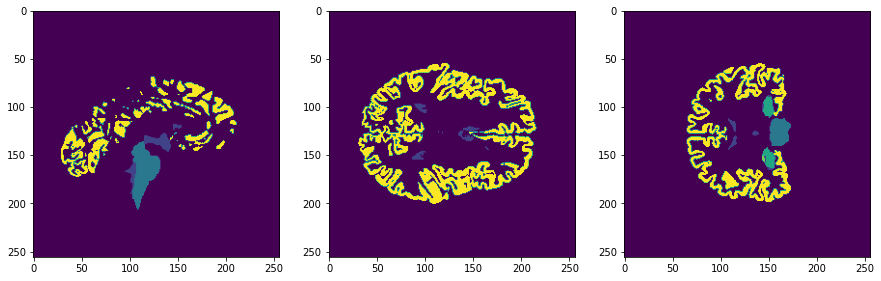

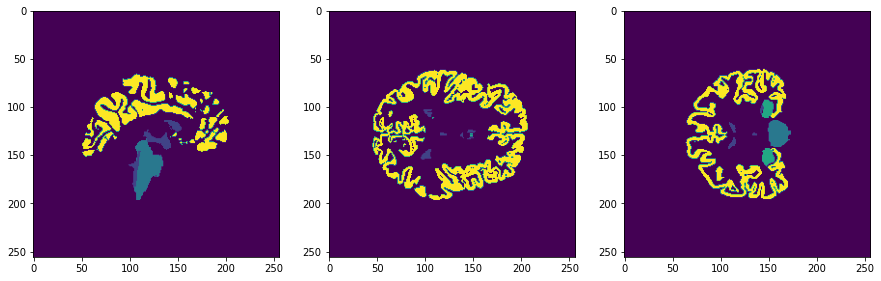

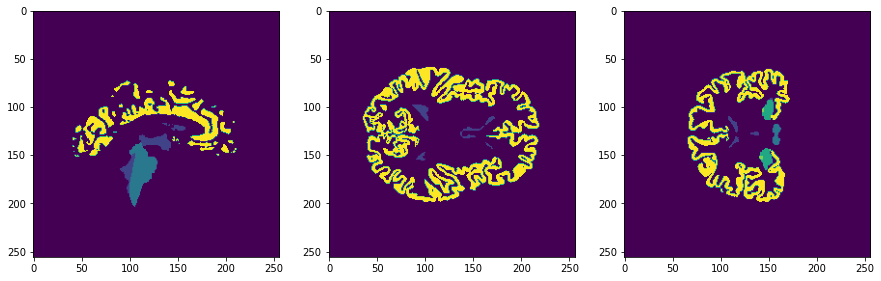

In [ ]:
test_subjects = [100206, 100307, 100408]

testing_data_list = pd.DataFrame({
    'Subject': test_subjects,
    'norm': [f'{test_dir}/HCP_T1_fs6_{subject}_norm.nii.gz' for subject in test_subjects],
    'aseg': [f'{test_dir}/HCP_T1_fs6_{subject}_aparc+aseg.nii.gz' for subject in test_subjects]
})

testing_data, testing_subjects = get_torchio_dataset(testing_data_list['norm'], testing_data_list['aseg'], False)
testing_set = torchio.SubjectsDataset(
    testing_subjects, transform=validation_transform)

for idx in range(0,3):
    sample = testing_set[idx]
    plot_central_cuts(prepare_aseg(sample[LABEL][DATA][0]))

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_6_classes_4_blocks_8_chanels_crop_flip_anisotropy_blur_biasfield_scheduler_valbatch16_ep10_ep7_30_40.pth')))
predictions, test_scores = evaluate(model, testing_set, validation_batch_size=16, patch_size=64, patch_overlap=0)
print(test_scores)
print(f"\nTesting score: DICE {test_scores}")
print(f"\nTesting mean score: DICE {np.mean(test_scores):0.3f}")

In [ ]:
df_scores_aug = pd.read_csv(scores_dir + 'scores_6_classes_4_blocks_8_chanels_crop_flip_anisotropy_blur_biasfield_scheduler_valbatch16_ep40_0.csv', sep=';')
df_scores_no_aug = pd.read_csv(scores_dir + 'scores_6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_ep40_0.csv', sep=';')

Visualization of the results:

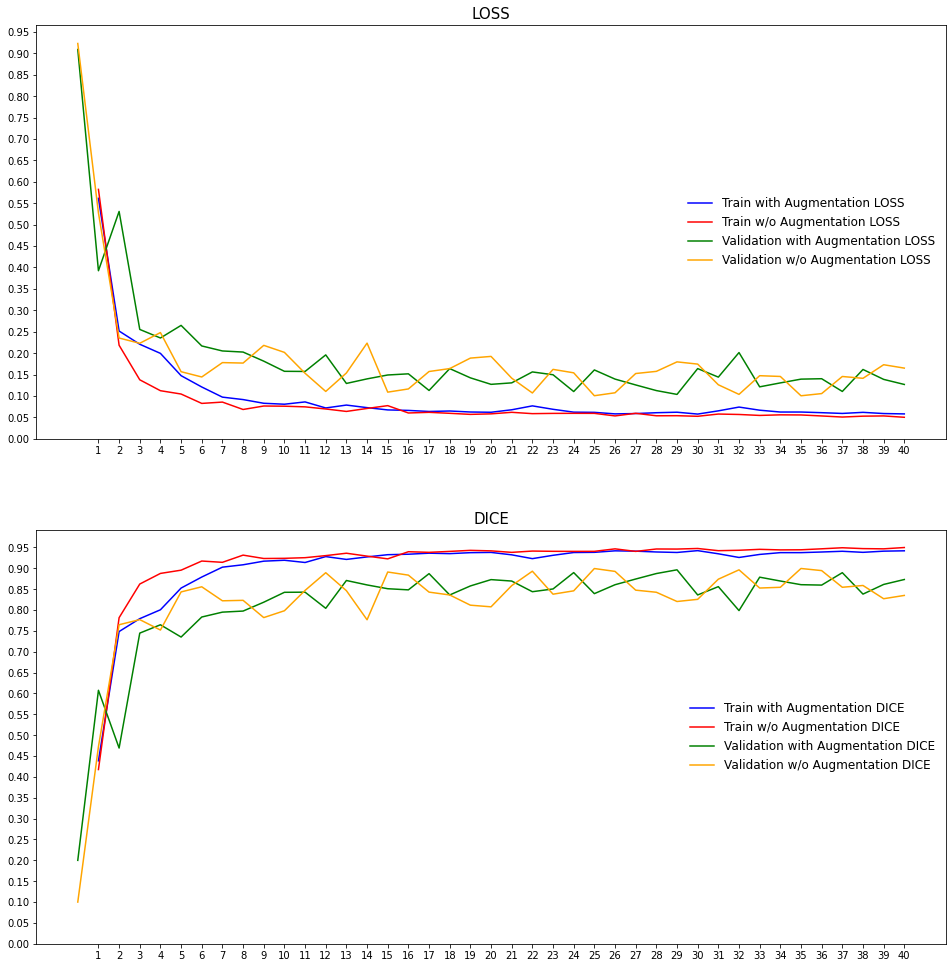

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
fig.tight_layout(pad=7.0)

ax[0].set_title('LOSS', size=15)
ax[0].plot(df_scores_aug.index, df_scores_aug.avg_train_loss, label = 'Train with Augmentation LOSS', color = 'blue')
ax[0].plot(df_scores_no_aug.index, df_scores_no_aug.avg_train_loss, label = 'Train w/o Augmentation LOSS', color = 'red')
ax[0].plot(df_scores_aug.index, df_scores_aug.avg_val_loss, label = 'Validation with Augmentation LOSS', color = 'green')
ax[0].plot(df_scores_no_aug.index, df_scores_no_aug.avg_val_loss, label = 'Validation w/o Augmentation LOSS', color = 'orange')
ax[0].legend(loc=7, fontsize=12, frameon=False)
ax[0].set_xticks(np.arange(1, 41, step=1))
ax[0].set_yticks(np.arange(0, 1, step=0.05))

ax[1].set_title('DICE', size=15)
ax[1].plot(df_scores_aug.index, df_scores_aug.avg_train_dice, label = 'Train with Augmentation DICE', color = 'blue')
ax[1].plot(df_scores_no_aug.index, df_scores_no_aug.avg_train_dice, label = 'Train w/o Augmentation DICE', color = 'red')
ax[1].plot(df_scores_aug.index, df_scores_aug.avg_val_dice, label = 'Validation with Augmentation DICE', color = 'green')
ax[1].plot(df_scores_no_aug.index, df_scores_no_aug.avg_val_dice, label = 'Validation w/o Augmentation DICE', color = 'orange')
ax[1].legend(loc=7, fontsize=12, frameon=False)
ax[1].set_xticks(np.arange(1, 41, step=1))
ax[1].set_yticks(np.arange(0, 1, step=0.05))

plt.show()

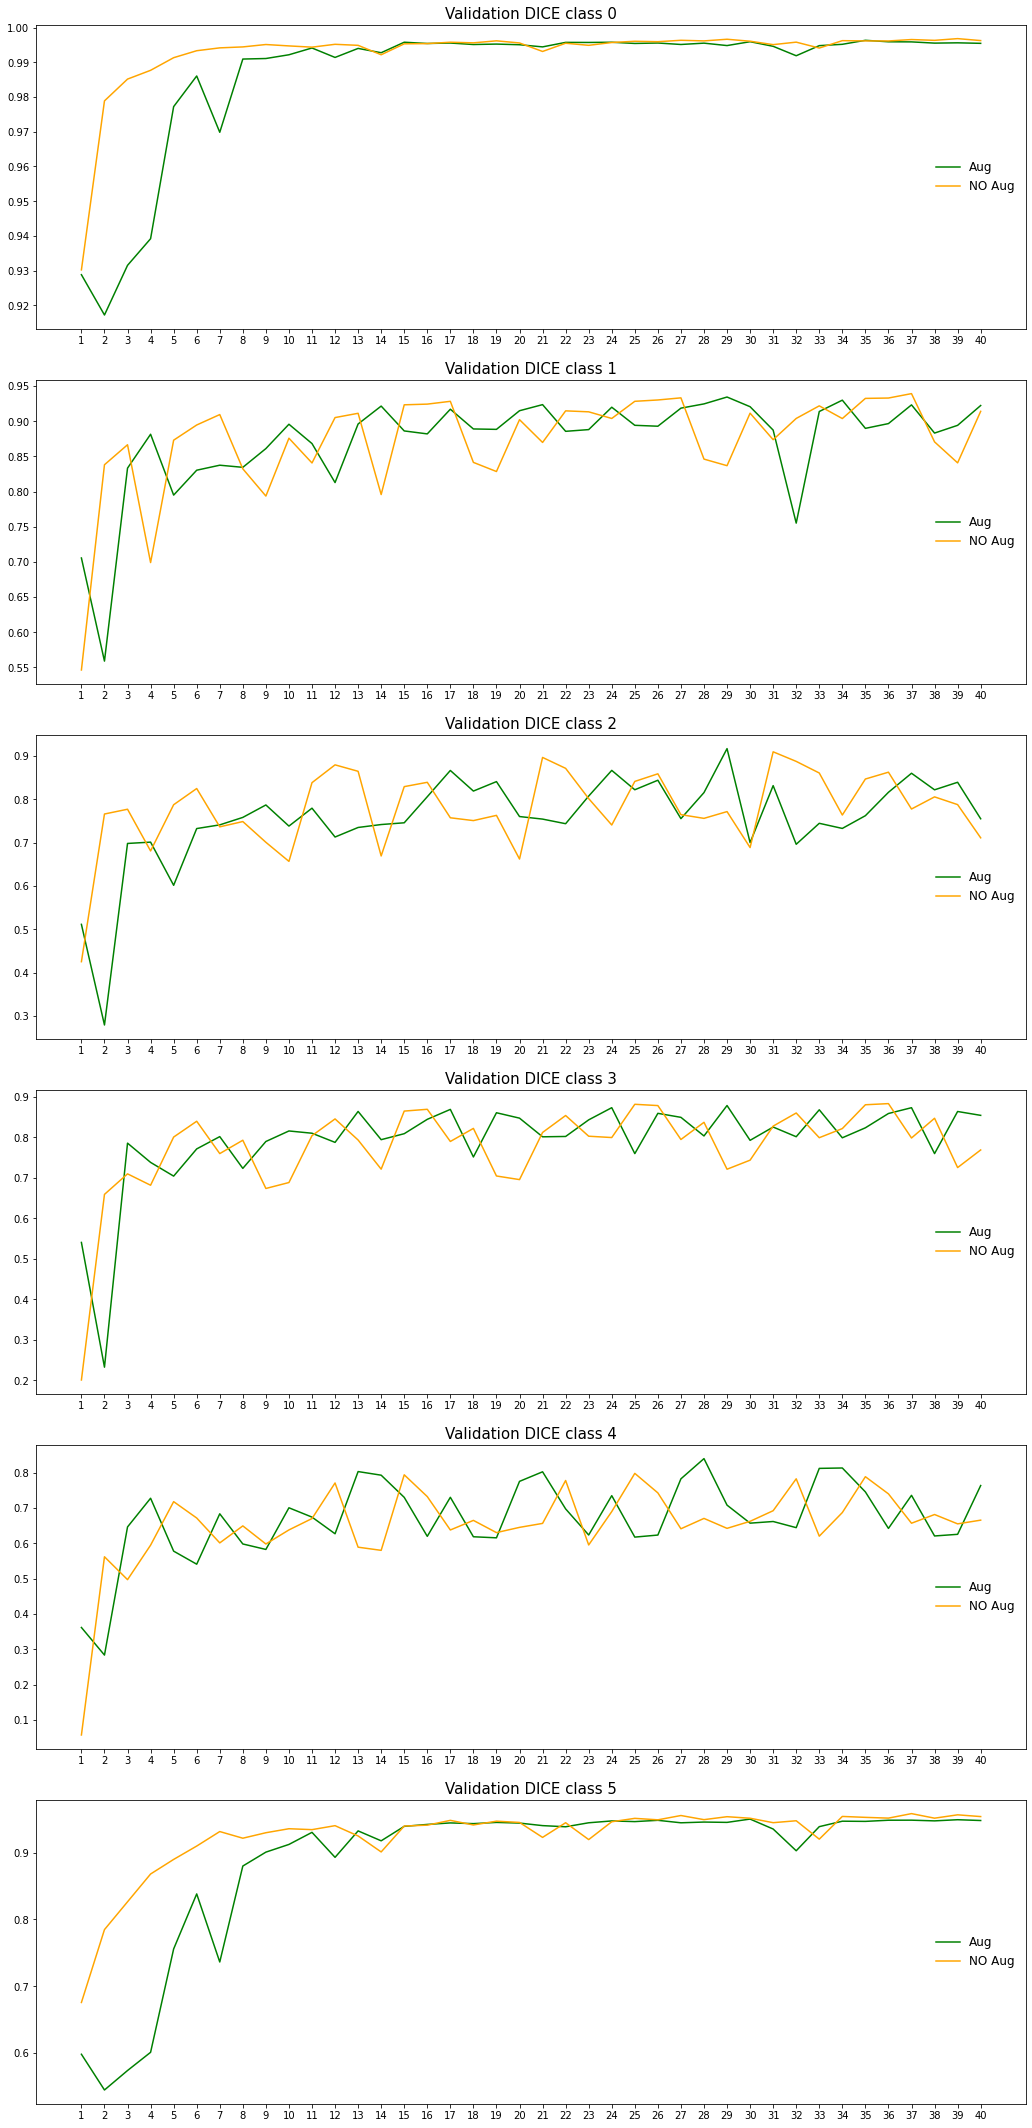

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(15, 30))
fig.tight_layout(pad=3.0)

for idx in range(0,6):
    ax[idx].set_title(f'Validation DICE class {idx}', size=15)
    ax[idx].plot(df_scores_aug.index, df_scores_aug[f'val_dice_{idx}'], label = 'Aug', color = 'green')
    ax[idx].plot(df_scores_no_aug.index, df_scores_no_aug[f'val_dice_{idx}'], label = 'NO Aug', color = 'orange')
    ax[idx].legend(loc=7, fontsize=12, frameon=False)
    ax[idx].set_xticks(np.arange(1, 41, step=1))
plt.show()

Extra validation of the model using the Hausdorff distance:

In [ ]:
def validate(label, pred):
    ''' Computes DICE and Hausdorf95 measures
    '''

    test_res = pd.DataFrame(columns = ['DICE_1', 'DICE_2', 'DICE_3', 'DICE_4', 'DICE_5',
                                      'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3', 'Hausdorff95_4', 'Hausdorff95_5'])
    # class 1
    distances = metrics.compute_surface_distances((label[0] == 1), (pred[0].numpy() == 1), [1,1,1])
    test_res.at[0,'DICE_1'] = metrics.compute_dice_coefficient((label[0] == 1), (pred[0].numpy() == 1))
    test_res.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 2
    distances = metrics.compute_surface_distances((label[0] == 2), (pred[0].numpy() == 2), [1,1,1])
    test_res.at[0,'DICE_2'] = metrics.compute_dice_coefficient((label[0] == 2), (pred[0].numpy() == 2))
    test_res.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 3
    distances = metrics.compute_surface_distances((label[0] == 3), (pred[0].numpy() == 3), [1,1,1])
    test_res.at[0,'DICE_3'] = metrics.compute_dice_coefficient((label[0] == 3), (pred[0].numpy() == 3))
    test_res.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 4
    distances = metrics.compute_surface_distances((label[0] == 4), (pred[0].numpy() == 4), [1,1,1])
    test_res.at[0,'DICE_4'] = metrics.compute_dice_coefficient((label[0] == 4), (pred[0].numpy() == 4))
    test_res.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 5
    distances = metrics.compute_surface_distances((label[0] == 5), (pred[0].numpy() == 5), [1,1,1])
    test_res.at[0,'DICE_5'] = metrics.compute_dice_coefficient((label[0] == 5), (pred[0].numpy() == 5))
    test_res.at[0,'Hausdorff95_5'] = metrics.compute_robust_hausdorff(distances, 95)

    return test_res

Comparing three models, the one from the teacher and two models we got during experiments with some augmentations:

model_6_classes_4_blocks_8_chanels_Kate_baseline.pth


/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


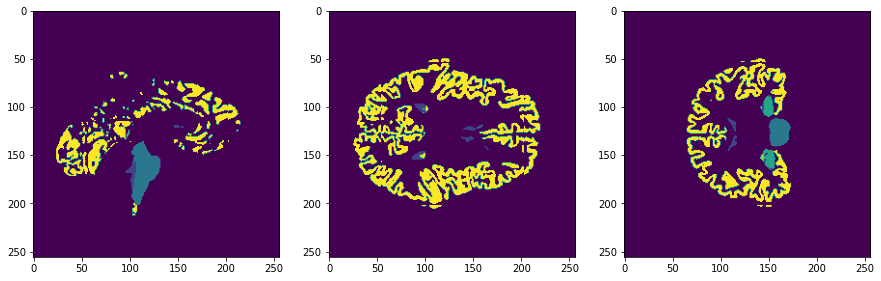

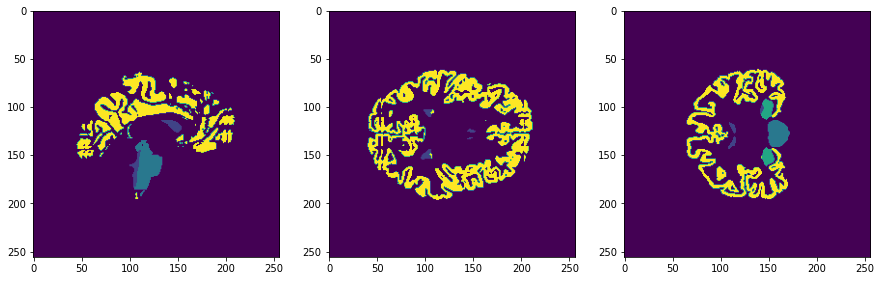

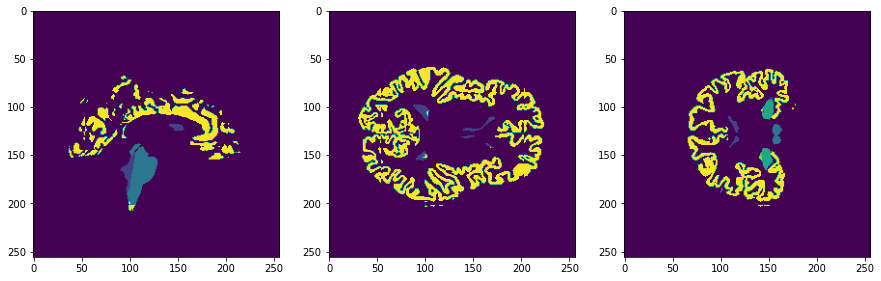

     DICE_1    DICE_2    DICE_3    DICE_4    DICE_5 Hausdorff95_1 Hausdorff95_2 Hausdorff95_3 Hausdorff95_4 Hausdorff95_5
0  0.874538  0.945721  0.916003  0.881886  0.870469        10.247       1.41421             1             1             2
1  0.879801  0.924606   0.90907  0.889132  0.907988       10.6301             3             1             1             1
2  0.886608  0.952879  0.910146  0.877031  0.868691       9.48683             1             1             1       1.73205
model_6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_10_20_30_40.pth


/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


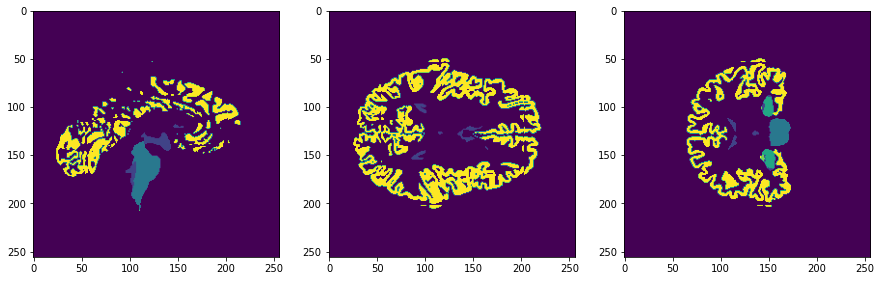

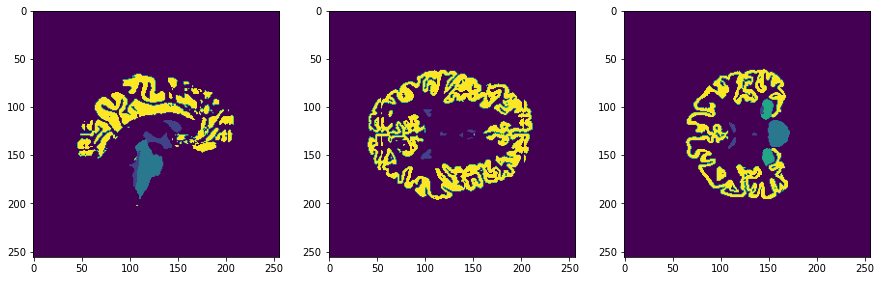

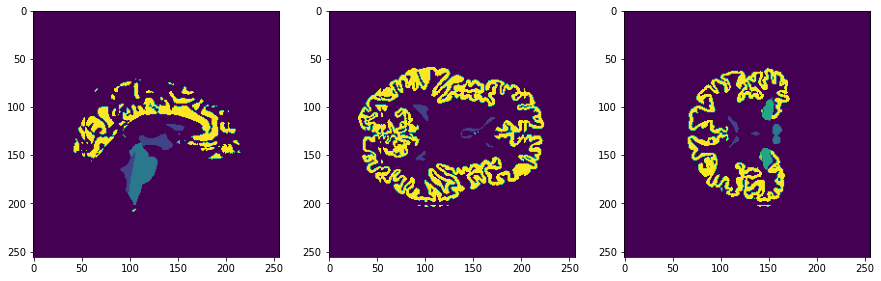

     DICE_1    DICE_2    DICE_3    DICE_4    DICE_5 Hausdorff95_1 Hausdorff95_2 Hausdorff95_3 Hausdorff95_4 Hausdorff95_5
0  0.919045   0.95522   0.92159   0.88894  0.887054             1             1             1             1             2
1  0.918744   0.94305  0.913805  0.892033  0.927231             1       1.73205             1             1             1
2  0.928062  0.961151  0.915902  0.894267  0.894201             1             1             1             1       1.41421
model_6_classes_4_blocks_8_chanels_crop_flip_anisotropy_blur_biasfield_scheduler_valbatch16_ep10_ep7_30_40.pth


/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


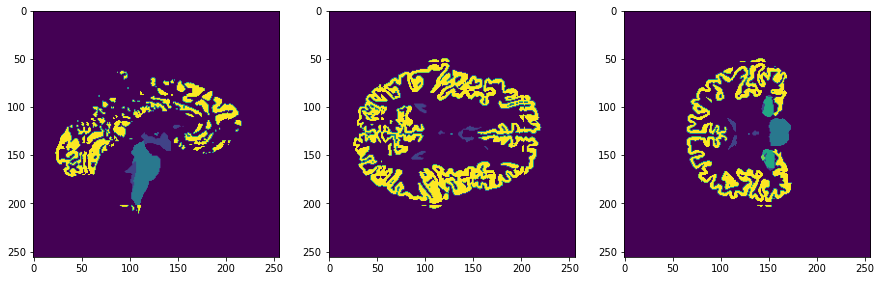

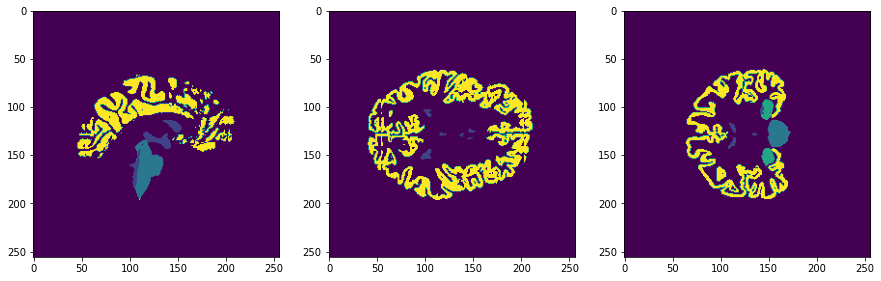

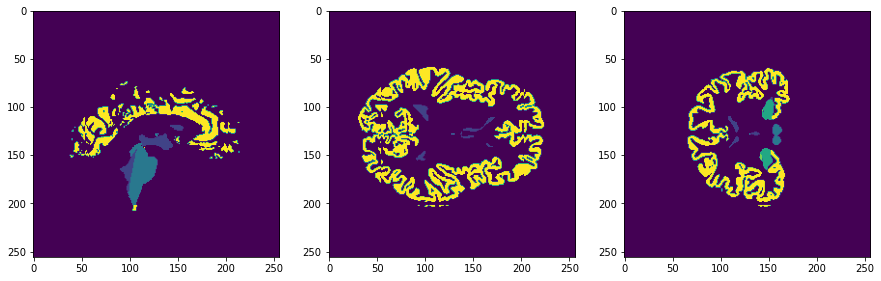

     DICE_1    DICE_2    DICE_3    DICE_4    DICE_5 Hausdorff95_1 Hausdorff95_2 Hausdorff95_3 Hausdorff95_4 Hausdorff95_5
0  0.913891  0.954342  0.915322  0.887742  0.882257             1             1             1             1       2.23607
1  0.909892  0.943293  0.910658  0.884249  0.922391             1             2             1             1             1
2  0.925711  0.956748  0.911064  0.881926  0.888431             1             1             1             1       1.41421


In [ ]:
models = ['model_6_classes_4_blocks_8_chanels_Kate_baseline.pth', 'model_6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_10_20_30_40.pth', 'model_6_classes_4_blocks_8_chanels_crop_flip_anisotropy_blur_biasfield_scheduler_valbatch16_ep10_ep7_30_40.pth']
for item in models:
    print(item)
    model.load_state_dict(torch.load(os.path.join(model_dir, item)))
    res_pivot = pd.DataFrame()
    for i in range(0, len(testing_set)):
        sample = testing_set[i]
        patch_size = 64, 64, 64
        patch_overlap = 20
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=8)
        aggregator = torchio.inference.GridAggregator(grid_sampler)

        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = model(inputs.float())
                labels = logits.argmax(dim=1, keepdim=True)
                aggregator.add_batch(labels, locations)

        pred = aggregator.get_output_tensor()
        label = prepare_aseg(testing_set[i][LABEL][DATA])
        plot_central_cuts(pred)
        temp_df = validate(label, pred)
        res_pivot = res_pivot.append(temp_df, ignore_index =True)

    print(res_pivot.to_string())

Using data with pathological changes of target structures to prove that the quality of the model is enough to observe the changes:

In [ ]:
len(os.listdir(patology_data_dir))

In [ ]:
os.listdir(patology_data_dir)[:-1]

In [ ]:
pat_labels_dir  = '/content/drive/My Drive/la5/'
pat_labels = pd.read_csv(pat_labels_dir + 'LA5study_targets.csv')

patology_data_list = pd.DataFrame(columns = ['Subject', 'diagnosis', 'norm','aseg'])
patology_data_list['Subject'] = pat_labels['participant_id']
patology_data_list['diagnosis'] = pat_labels['diagnosis']

for i in tqdm(os.listdir(patology_data_dir)[:-1]):
  for j in range(0, len(patology_data_list['Subject'])):

    if str(patology_data_list['Subject'].iloc[j]) in i:
      if 'norm' in i: # copying path to the column norm
        patology_data_list['norm'].iloc[j] = patology_data_dir +'/'+ i
      elif 'aseg' in i: # copying path to second column
        patology_data_list['aseg'].iloc[j] = patology_data_dir +'/'+ i

patology_data_list.dropna(inplace= True)

100%|██████████| 530/530 [00:01<00:00, 409.13it/s]


In [ ]:
patology_data_list['diagnosis'].unique()

array(['CONTROL', 'SCHZ', 'ADHD', 'BIPOLAR'], dtype=object)

In [ ]:
patology_data_list['diagnosis'].value_counts()

CONTROL    125
SCHZ        50
BIPOLAR     49
ADHD        41
Name: diagnosis, dtype: int64

In [ ]:
patology_data, patology_subjects = get_torchio_dataset(patology_data_list['norm'], patology_data_list['aseg'], False)
patology_set = torchio.SubjectsDataset(patology_subjects, transform=validation_transform)

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_6_classes_4_blocks_8_chanels_crop_flip_anisotropy_blur_biasfield_scheduler_valbatch16_ep10_ep7_30_40.pth')))
pat_predictions, pat_test_scores = evaluate(model, patology_set, validation_batch_size=16, patch_size=64, patch_overlap=0)
print(pat_test_scores)
print(f"\nTesting score: DICE {pat_test_scores}")
print(f"\nTesting mean score: DICE {np.mean(pat_test_scores):0.3f}")


In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)
models = ['model_6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_10_20_30_40.pth']
for item in models:
    print(item)
    model.load_state_dict(torch.load(os.path.join(model_dir, item)))
    res_pivot = pd.DataFrame()
    for i in range(0, len(patology_set)):
        sample = patology_set[i]
        patch_size = 64, 64, 64
        patch_overlap = 20
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=8)
        aggregator = torchio.inference.GridAggregator(grid_sampler)

        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = model(inputs.float())
                labels = logits.argmax(dim=1, keepdim=True)
                aggregator.add_batch(labels, locations)

        pred = aggregator.get_output_tensor()
        label = prepare_aseg(patology_set[i][LABEL][DATA])
        temp_df = validate(label, pred)
        res_pivot = res_pivot.append(temp_df, ignore_index =True)
    res_pivot.to_csv(scores_dir + f'scores_patology_dice_hausdorff.csv')


model_6_classes_4_blocks_8_chanels_crop_flip_scheduler_valbatch16_10_20_30_40.pth


/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)
